In [1]:
from mne.io import read_raw_fif
import mne
from brainpipe.feature import power
import numpy as np
import neurokit
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind

%matplotlib notebook

In [2]:
# 1.
# Fetch time series data from any file whatsoever
# Must be at least 30 seconds at 250Hz

raw_rs = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz', preload=True).resample(250)
raw_task = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz', preload=True).resample(250)
sfreq = raw_rs.info['sfreq']

Opening raw data file /home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz...


<ipython-input-2-c5cea1a0582e>:5: RuntimeWarning: This filename (/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_rs = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_01_preprocessed.fif.gz', preload=True).resample(250)


    Read 5 compensation matrices
    Range : 0 ... 431999 =      0.000 ...   359.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 431999  =      0.000 ...   359.999 secs...
Opening raw data file /home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz...


<ipython-input-2-c5cea1a0582e>:6: RuntimeWarning: This filename (/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_task = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz', preload=True).resample(250)


    Read 5 compensation matrices
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 587999  =      0.000 ...   489.999 secs...
Trigger channel has a non-zero initial value of 10 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1603 events found
Event IDs: [21 31 99]
Trigger channel has a non-zero initial value of 10 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1595 events found
Event IDs: [21 31 99]


<ipython-input-2-c5cea1a0582e>:6: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw_task = read_raw_fif('/home/hyruuk/GitHub/my_eegsynth/datafiles/SA04_02_preprocessed.fif.gz', preload=True).resample(250)


In [ ]:
raw_task.info['ch_names']

In [ ]:
raw.picks(picks)

In [7]:

def slice_into_epochs(raw, n_timepoints=3000):
    # Takes the first 4 chans, average them and slice into epochs
    picks = mne.pick_types(raw.info, meg=True, eeg=False)
    all_timeseries = np.mean(raw.get_data(picks=picks)[1:5,:], axis=0)
    
    xs = np.array([x for x in range(0, raw_rs.get_data(picks=picks).shape[1], 3000)])
    eeg_timeseries = []
    for x in xs:
        start = x
        stop = x + 3000
        if stop < len(all_timeseries):
            eeg_timeseries.append(all_timeseries[start:stop])
    timeseries = np.array(eeg_timeseries)
    return timeseries

timeseries_rs = slice_into_epochs(raw_rs, n_timepoints=3000)
timeseries_task = slice_into_epochs(raw_task, n_timepoints=3000)
    

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [ ]:
# 2.
# Compute hilbert using brainpipe
def get_hilbert(data, freq=1):
    # data = n_elec * n_timepoints
    f = [[4, 8], [8, 12], [12, 30]]
    power_obj = power(sf, npts=data.shape[1], f=f, baseline=None, norm=None, method='hilbert', window=None, width=None, step=None, split=None, time=None)
    power_vals = power_obj.get(data.T)[0].squeeze() # get power values across time
    pow_timecourse = np.average(power_vals[freq,:,:], axis=1) # average sensors and retain the desired freq << must be optimized
    t = np.arange(0,len(pow_timecourse),1)
    plt.plot(t, pow_timecourse)
    plt.show()
    return pow_timecourse

dtp = get_hilbert(eeg_timeseries, freq=1)

eeg = np.mean(eeg_timeseries, axis=0)

In [ ]:
# 3.
# Compute complexity using neurokit
start = time.time()
comp = neurokit.complexity(eeg_timeseries)
stop = time.time()
print("duration of computation :")
print(stop-start)
print(comp)


In [ ]:
# Let's do the same with simulated data ! 
np.random.seed(0) 
fs = 250
fund_freq = 0.2
dur = 30
samples = np.linspace(0, dur, dur * fs)
print(samples)
pure = np.sin(2 * np.pi * fund_freq * samples)
noise = np.random.normal(0, 1, pure.shape)
sim_signal = pure + noise

plt.plot(pure)
plt.show()
plt.plot(noise)
plt.show()
plt.plot(sim_signal)
plt.show()




eeg_freqenv = get_hilbert(eeg_timeseries, freq=2)
comp = []
names = ['pure', 'noise', 'sim_signal', 'eeg_freqenv']
for i, data in enumerate([pure, noise, sim_signal, eeg_freqenv]):
    comp.append(comp_compute(data, names[i]))
    

In [33]:
from mne.datasets import sleep_physionet
dl_path = sleep_physionet.age.fetch_data(subjects=[0], recording=[1]) # Downloads the sleep dataset
data_path = dl_path[0][0] # Get path of datafile
annot_path = dl_path[0][1] # Get path of annotations (sleep stages info) file


raw_data = mne.io.read_raw_edf(data_path) # Read datafile
sfreq = raw_data.info['sfreq'] # We'll need to keep this for later
annot = mne.read_annotations(annot_path) # Read sleep stages annotation file
raw_data.set_annotations(annot, emit_warning=False) # Link annotations to data

# With these files, MNE -wrongly- recognizes all channels as EEG.
# So we need to tell it which channel isn't EEG
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}
raw_data.set_channel_types(mapping)
picks = mne.pick_types(raw_data.info, meg=False, eeg=True) # keep EEG indices in picks


# Segment data into epochs of different conditions (ex. wake vs sleep)
## first declare some variables
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

tmax = 30. - 1. / sfreq # define duration of an epoch, here we will take 30 seconds in order to reach 3000pts

## find events from annotations file
events, _ = mne.events_from_annotations(
    raw_data, event_id=annotation_desc_2_event_id, chunk_duration=tmax)

## segment datafile based on events
epochs = mne.Epochs(raw=raw_data, events=events, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

## split epochs in the two conditions
ep_wake = np.average(epochs['Sleep stage W'].get_data(picks=picks), axis=1)
ep_sleep = np.average(epochs['Sleep stage 3/4'].get_data(picks=picks), axis=1)



Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /home/hyruuk/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
2650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 1997 events and 3000 original time points ...
0 bad epochs dropped
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped


In [31]:
def comp_compute(data, verbose=False, compute='hurst'):
    shannon, sampen, multiscale, spectral, svd, correlation, higushi, petrosian, fisher, hurst, dfa, lyap_r, lyap_e = False, False, False, False, False, False, False, False, False, False, False, False, False

    if compute == 'shannon':
        shannon = True
    if compute == 'sampen':
        sampen = True
    if compute == 'multiscale':
        multiscale = True
    if compute == 'spectral': #### Maybe that huge wall can be improved
        spectral = True
    if compute == 'svd':
        svd = True
    if compute == 'correlation':
        correlation = True
    if compute == 'higushi':
        higushi = True
    if compute == 'petrosian':
        petrosian = True
    if compute == 'fisher':
        fisher = True
    if compute == 'hurst':
        hurst = True
    if compute == 'dfa':
        dfa = True
    if compute == 'lyap_r':
        lyap_r = True
    if compute == 'lyap_e':
        lyap_e = True

    start = time.time()
    comp = neurokit.complexity(data, sampling_rate=sfreq, 
                               shannon=shannon, 
                               sampen=sampen, 
                               multiscale=multiscale, 
                               spectral=spectral, 
                               svd=svd, 
                               correlation=correlation, 
                               higushi=higushi, 
                               petrosian=petrosian, 
                               fisher=fisher, 
                               hurst=hurst, 
                               dfa=dfa, 
                               lyap_r=lyap_r, 
                               lyap_e=lyap_e, 
                               emb_dim=2, tolerance="default", k_max=8, bands=None, tau=1)
    stop = time.time()
    
    if verbose==True:
        print("Computed in {} seconds".format(stop-start))
        print(comp)
        
    metric_name = [i for i in comp.keys()][0]
    return comp[metric_name]


def compute_A_vs_B(ep_cond1, ep_cond2, compute='hurst'):
    n_epochs = np.min([ep_cond1.shape[0], ep_cond2.shape[0]])  # The maximum number of epochs we can compare is constrained by the number of sleep epochs
    comp_cond1 = []
    comp_cond2 = []
    for epoch_id in range(n_epochs):
        comp_cond1.append(comp_compute(ep_cond1[epoch_id,:], compute=compute))
        comp_cond2.append(comp_compute(ep_cond2[epoch_id,:], compute=compute))
    comp_cond1 = np.array(comp_cond1)
    comp_cond2 = np.array(comp_cond2)
    tval, pval = ttest_ind(comp_cond1, comp_cond2)
    print('{} binomial pval with N={}, : {}'.format(compute, n_epochs, pval))
    return comp_cond1, comp_cond2, pval, n_epochs


def plot_A_vs_B(comp_cond1, comp_cond2, cond_names, pval, met, ax=None):
    ######### Create a boxplot
    
    #### Create dataframe for Seaborn
    values = np.hstack((comp_cond1, comp_cond2))
    condition = np.hstack(([cond_names[0]]*len(comp_cond1), [cond_names[1]]*len(comp_cond2)))
    d = {'Values': values, 'Condition': condition}
    df = pd.DataFrame(data=d)
    
    if ax == None:
        f, ax = plt.subplots(figsize=(7, 6))
    
    # Create boxes
    sns.boxplot(x="Condition", y="Values", data=df,
                whis="range", ax=ax)
    
    if len(comp_cond1) >= 50: # If n_epochs > 50 we use a violinplot  
        sns.violinplot(x="Condition", y="Values", data=df,
                      size=2, linewidth=0.5, ax=ax, palette='vlag')
    else: # Add in points to show each observation
        sns.swarmplot(x="Condition", y="Values", data=df,
              size=10, linewidth=0.5, ax=ax, palette='vlag')
    
    # Tweak the visual presentation
    ax.xaxis.grid(True);
    sns.despine(trim=True, left=True, ax=ax)
    
    # Add pvals in title
    if pval <= 0.05 and pval >= 0.001:
        ax.set_title(met + ' *')
    elif pval <= 0.001 and pval >= 0.0001:
        ax.set_title(met + ' **')
    elif pval <= 0.0001:
        ax.set_title(met + ' ***')
    else:
        ax.set_title(met)
        
    return ax

hurst binomial pval with N=220, : 3.334238143253699e-61
fisher binomial pval with N=220, : 3.125298698214363e-175


/home/hyruuk/anaconda3/envs/cbc/lib/python3.7/site-packages/neurokit/signal/complexity.py:526: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)


higushi binomial pval with N=220, : 1.3482663055823895e-248


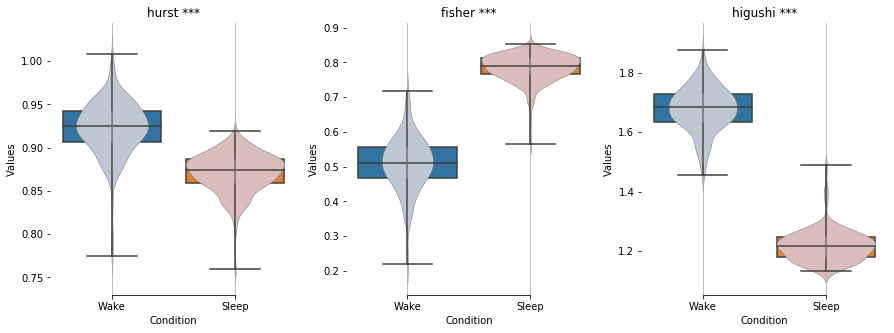

In [34]:



metrics = ['hurst', 'fisher', 'higushi']
fig, ax = plt.subplots(1, len(metrics), figsize=(5*(len(metrics)),5))
cond_names = ['Wake', 'Sleep']
for i, met in enumerate(metrics):
    # I'd love to keep only the first Y label but no idea how
    comp_wake, comp_sleep, pval,_ = compute_A_vs_B(ep_wake, ep_sleep, met)
    plot_A_vs_B(comp_wake, comp_sleep, cond_names, pval, met, ax=ax[i])

## Ok, so these metrics seem to be discriminant

But how do they behave when computed in pseudo-realtime ?


In [ ]:
comp_task

hurst binomial pval with N=29, : 0.39630497671795806
svd binomial pval with N=29, : 0.14756651105114105


/home/hyruuk/anaconda3/envs/cbc/lib/python3.7/site-packages/neurokit/signal/complexity.py:526: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (p, r1, r2, s)=np.linalg.lstsq(x, L)


higushi binomial pval with N=29, : 0.022467991415925488


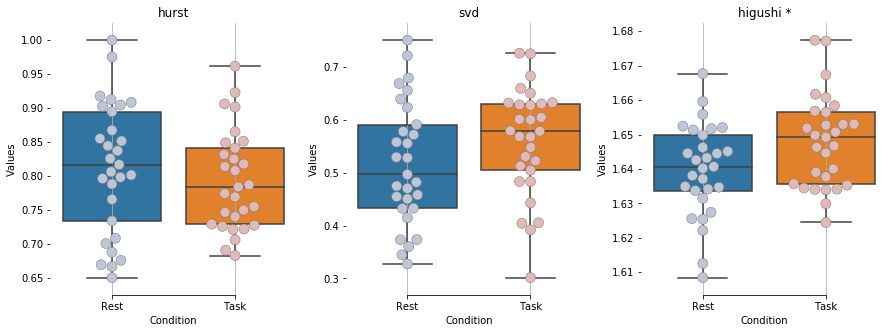

In [32]:
#### WITH MY OWN DATA =D

metrics = ['hurst', 'svd', 'higushi']
cond_names = ['Rest', 'Task']
fig, ax = plt.subplots(1, len(metrics), figsize=(5*(len(metrics)),5))

for i, met in enumerate(metrics):
    # I'd love to keep only the first Y label but no idea how
    comp_rs, comp_task, pval,_ = compute_A_vs_B(timeseries_rs, timeseries_task, compute=met)
    plot_A_vs_B(comp_rs, comp_task, cond_names, pval, met, ax=ax[i])
    
plt.savefig('complexity_Task_v_Rest.png', dpi=600)

In [13]:
import os
os.getcwd()

'/home/hyruuk/GitHub/realtime-nonlinear'

In [ ]:
comp_rs

In [ ]:
### I want a plot that shows computation times for the different metrics

In [ ]:
# What am I going to plot ???
# I want an interactive plot that shows the effect of adding +- of noise to the signal, 
# and check the changes on complexity measures.
# Barplot of the differents comp measures (Hurst, DFA, SVDE, SpectralE)


### I want to compare Higuchi, Hurst and DFA between sleep and wake
#- DONE

### I want to compare HHD 